In [11]:
#######################################################################
### library/Module Import  
#######################################################################
import os, torch, PIL, torch, glob, time, random, math, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torch import nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler,SubsetRandomSampler,SequentialSampler,BatchSampler

from torchvision import transforms
from torchvision import transforms, models

from torchsummary import summary

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [12]:

#######################################################################
### Define Dataset with image preprovrddin
#######################################################################

class PCB_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path:str, Train=True):
        super().__init__()
        
        self.data_path = data_path 
        self.class_path = glob.glob(data_path+"*")
        self.data = []
        
        self.Train=Train
        
        class_name_set = []
        
        for i_class_path in self.class_path:
            
            class_name = i_class_path.split("\\")[-1]
            
            class_name_set.append(class_name)
            
            for img_path in glob.glob(i_class_path + "\\*.jpg"):
                
                if "Current" in img_path:
                    
                    self.data.append([img_path, class_name])
        
        class_name_set.sort()## sort class name by alphabet order
        
        self.class_to_idx = dict(zip(class_name_set, range(len(class_name_set))))            
                    

    
        self.Train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(),
            #transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
                
        self.Valid_Test_transform = transforms.Compose([
            #transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
                

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx:int):
        
        Current_img_path, class_name = self.data[idx]
        Master_img_path = f"{Current_img_path[:-11]}Master.jpg"
        
        if self.Train:
            Current_img = self.Train_transform(PIL.Image.open(Current_img_path))
            Master_img = self.Train_transform(PIL.Image.open(Master_img_path))

        else:
            
            Current_img = self.Valid_Test_transform(PIL.Image.open(Current_img_path))
            Master_img = self.Valid_Test_transform(PIL.Image.open(Master_img_path))

        label = self.class_to_idx[class_name]
                        
        return Current_img, Master_img, label, Current_img_path, Master_img_path



In [13]:


####################################################################
###  Define Earlystop module
###################################################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=True,
                 delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_acc = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, val_acc, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_acc = val_acc
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_acc = val_acc
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define modules for the proposed model

In [14]:
### Resnet model Modules

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        
         #no feature_map size if strid==1        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        #no feature_map size
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.downsample = downsample
        self.stride = stride

        #no use of cbam in general case
        if use_cbam:
            #self.cbam = CBAM( planes, 16 )
            pass
        
        else:
            self.cbam = None

    def forward(self, x):
        
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        #downsample
        if self.downsample is not None:
            residual = self.downsample(x)

        #cbam 
        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ChannelPool(nn.Module):
    def __init__(self):
        super(ChannelPool, self).__init__()
        self.conv = nn.Conv2d(512, 2, kernel_size=1, stride=1,
                     padding=0, bias=False)   
    def forward(self, x):
        #results =  torch.mean(x,1).unsqueeze(1)\
        results =  self.conv(x)
        return results

In [15]:
#############################################################################
### Define the proposed model's architecture
##############################################################################

class VIB_ResNet(nn.Module):

    def __init__(self, block, layers,  network_type, num_classes, att_type=None, num_latent=512):

        super(VIB_ResNet, self).__init__()
        self.inplanes = 64
        self.num_latent = num_latent
        self.compress = ChannelPool()
        self.sigmoid = nn.Sigmoid()
        
        
        self.network_type = network_type
        # different model config between Large size (ImageNet) and Small Size(CIFAR) 
        if network_type == "Large_size":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(10)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            #self.bam1 = BAM(64*block.expansion)
            #self.bam2 = BAM(128*block.expansion)
            #self.bam3 = BAM(256*block.expansion)
            pass
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None
        
        
        # layer2: 3*3 conv2d & 64-Inchannel -> 64-Outchannel with no atten
        # layer2's feature map 75*75
        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        
        # layer3: 64-Inchannel -> 128-Outchannel with no atten
        # layer3's feature map 38*38
        # 3*3 conv2d with 2-stride + 1-pad & downsampling in only layer3's first
        # 3*3 conv2d with 1-stride + 1-pad & no downsampling in layer3's second 
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        
        # layer4: 128-Inchannel -> 256-Outchannel with no atten
        # layer4's feature map 19*19
        # 3*3 conv2d with 2-stride + 1-pad & downsampling in only layer4's first
        # 3*3 conv2d with 1-stride + 1-pad & no downsampling in layer4's second
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        
        # layer5: 256-Inchannel -> 512-Outchannel with no atten
        # layer5's feature map 10*10
        # 3*3 conv2d with 2-stride + 1-pad & downsampling in only layer5's first
        # 3*3 conv2d with 1-stride + 1-pad & no downsampling in layer5's second
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)
        
  
        
        #FC layer
        self.fc = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(100*512,1)
        )
        
        #fc layer parameters initialization**
        init.kaiming_normal_(self.fc[1].weight)
        
        #Other layer's parameters initialization**
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal_(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0
                
    #Define each block of resnet    
    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    #Define reparameterization trick model
    def reparameterize(self, mu, logVar):
        # Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar / 2)
        eps = torch.randn_like(std)
        return mu + std * eps

    #Define shames networks
    def sub_forward(self, x_master):
        x_master = self.conv1(x_master) # 150 feature size with 64 chann
        x_master = self.bn1(x_master)
        x_master = self.relu(x_master)
        
        if self.network_type == "Large_size":
            x_master = self.maxpool(x_master) # 75 feature siz
          
        x_master = self.layer1(x_master) # 75 feature size with 64 chann
        x_master = self.layer2(x_master) # 38 feature size with 128 channels and downsample 
        x_master = self.layer3(x_master) # 19 feature size with 256 channels and downsample
        x_master = self.layer4(x_master) # 10 feature size with 512 channels and downsample
        
        return x_master
    
    #Define forward process
    def forward(self, x_current, x_master, is_train=True):
        
        x_current = self.sub_forward(x_current)
        x_master = self.sub_forward(x_master)
        
        diff = self.relu(x_current-x_master)   
        diff = self.compress(diff) 
        diff = diff.view(diff.size(0), -1)
               
        mu = diff[:,100:]
        logVar = diff[:,:100].clamp(np.log(1e-2), -np.log(1e-2))  
            
        z = self.reparameterize(mu, logVar)     
    
        if(not is_train):
            z = mu
        
        
        prob_z = nn.functional.sigmoid(z)
        mask_z = nn.functional.relu(prob_z-0.7)
        mask_z = mask_z.view_as(x_current[:,0,:,:]).unsqueeze(1)
        new_x_current = torch.zeros_like(x_current)   
        new_x_current += x_current*mask_z
        fc_input = new_x_current.view(new_x_current.size(0),-1)
        pred = self.fc(fc_input)
        x_current = x_current.view(x_current.size(0),-1)
        x_master = x_master.view(x_master.size(0),-1)
        dist = torch.abs(x_current-x_master).mean(dim=1)#average l1 norm  
        
        return z, mu, logVar, mask_z, pred, dist, new_x_current, x_current#, x_current, x_master
            
### Define the final proposed model
def Variational_IB_ResNet(network_type, depth, num_classes, att_type, num_latent):

    assert network_type in ["Large_size", "Small_size"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = VIB_ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type, num_latent)

    elif depth == 34:
        model = VIB_ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type, num_latent)

    return model


In [16]:
#############################################################################
### Contrastive loss module
##############################################################################


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, dist, label):

        loss = torch.mean(1/2*(1-label) * torch.pow(dist, 2) +
                                      1/2*(label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))
        return loss


In [17]:
#############################################################################
### Define Training Module
##############################################################################


def train_model(Train_Valid_DataLoader_Set, model, class_criterion, contrastive_loss,
                optimizer, scheduler, earlystopping, num_epochs=25 , control_lambda=0.01, control_lambda2=0.001):
    
    since = time.time()
    
    history = {"train_loss": list(),
                        "valid_loss": list(),
                        "train_acc": list(),
                        "valid_acc": list()}
    
    breaker1, breaker2 = False, False
    
    for epoch in range(num_epochs):#tqdm-progressbar
        
        epoch_start = time.time()
        print("Epoch: %d/%d" % (epoch + 1, num_epochs))
        print('-' * 10)
        if breaker2:
            break
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if breaker1:    
                breaker2 = True
                break
            
            if phase == 'train':
                model.train()  # Set model to training mode
                is_train = True
            else:
                model.eval()   # Set model to evaluate m
                is_train = False
            
            epoch_loss = 0.0
            epoch_acc = 0
            epoch_examples = 0
            
            # Iterate over data.
            for i, (current_img, master_img, label, _, _) in enumerate(Train_Valid_DataLoader_Set[phase]):
                
                #(current_img, master_img, label, current_img_path, master_img_path) = iter(Train_Valid_DataLoader_Set['train']).__next__()
                
                current_input = current_img.to(device)
                master_input = master_img.to(device)
                target = label.to(device)
                          
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    z, mu, logVar, mask_z, output,  dist, new_x_current, x_current  = model(current_input, master_input, is_train =is_train)
                    del z, mask_z, new_x_current, x_current
                    
                    kl_loss = 0.5 * torch.sum(-1 - logVar + torch.exp(logVar) + mu**2, dim=1).mean()
                    cross_loss = class_criterion(output, target.unsqueeze(1).to(torch.float32))
                    loss2 = contrastive_loss(dist,target)
                    
                    loss = cross_loss + control_lambda*kl_loss + control_lambda2*loss2
                    
                    if phase=='train':
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()    
                        
                    predicted = torch.sigmoid(output)
                    predicted = (predicted>0.5).float()*1
                    
                # performance statistics
                # calculate sum of loss
                epoch_examples += target.size(0)
                
                if phase=='train':
                    epoch_loss += loss.item()*target.size(0)
                    
                else:
                    epoch_loss += cross_loss.item()*target.size(0)
                
                epoch_acc += (predicted == target.reshape(-1,1)).sum().item()
            
                del current_input, master_input, current_img, master_img, mu, logVar, dist
                del target
                del output
                del predicted
            
            
            # acc and loss per_sample_at each epoch
            loss_per_sample_epoch_ = epoch_loss/epoch_examples
            acc_per_sample_epoch = epoch_acc/epoch_examples
            epoch_end = time.time()
            epoch_time =  epoch_end - epoch_start
                        
             # save & print loss and acc
            if phase == 'train':
                scheduler.step()
                history["train_loss"].append(loss_per_sample_epoch_)
                history["train_acc"].append(acc_per_sample_epoch)
                print("Train - Loss: %.6f, Accuracy: %.2f, Time: %.2f" % (loss_per_sample_epoch_, acc_per_sample_epoch, epoch_time))
                 
                
            else:
                history["valid_loss"].append(loss_per_sample_epoch_)
                history["valid_acc"].append(acc_per_sample_epoch)
                print("Valid - Loss: %.6f, Accuracy: %.2f, Time: %.2f" % (loss_per_sample_epoch_, acc_per_sample_epoch, epoch_time))
                
                #earlystop working
                earlystopping(loss_per_sample_epoch_,acc_per_sample_epoch,model)
                
                if earlystopping.early_stop:
                    print("EARLY STOP")
                    
                    breaker1 = True
                    break
                        
                
    end = time.time()
    epoch_time = end - since
    print("Best - Loss: %.6f, Accuracy: %.2f, Time: %.2f" % (-earlystopping.best_score, 
                                                             earlystopping.best_acc, epoch_time))
    
    return history, earlystopping

## Train the proposed model

In [19]:
###########################################################################################################################
### Training Proposed model
###########################################################################################################################

### Set seed

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.autograd.set_detect_anomaly(True)

### Define dataset
data_path = r'D:/python_vscode/GRANDICT/20230802_4th_fixed_data/Temp4/'
Train_dataset = PCB_Dataset(data_path,Train=True)
Valid_dataset = PCB_Dataset(data_path,Train=False)
Test_dataset = PCB_Dataset(data_path,Train=False)
label_set = np.array([Train_dataset.class_to_idx[data[1]] for data in Train_dataset.data])


### Set GPU  
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
#os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPUs 2 and 3 to use
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPUs 2 and 3 to use


### Set hyperparmeters  
num_latent = 512
num_classes = 2
batch_size = 64
lr = 1*1e-4
batch_size = 64
num_train_epochs = 200
earlystop_patience = 25        

### Training the proposed model 10 times
seed_set = [1]
for seed in seed_set:
   
    set_random_seed(seed)
    gc.collect()
    torch.cuda.empty_cache()

    #Set dataLoader
    temp_data, test_data_idx = train_test_split(range(len(Train_dataset)),test_size = 0.2,stratify=label_set, random_state=seed)
    train_data_idx, valid_data_idx = train_test_split(temp_data,stratify=label_set[temp_data],test_size = 0.25,random_state=seed)

    train_sampler = SubsetRandomSampler(train_data_idx)
    valid_sampler = SubsetRandomSampler(valid_data_idx)
    test_sampler = SubsetRandomSampler(test_data_idx)

    train_dataLoader = DataLoader(Train_dataset,sampler=train_sampler, shuffle=False,batch_size=batch_size)
    valid_dataLoader = DataLoader(Valid_dataset,sampler=valid_sampler, shuffle=False,batch_size=batch_size)
    test_dataLoader = DataLoader(Test_dataset,sampler=test_sampler, shuffle=False,batch_size=batch_size)
    Train_Valid_DataLoader_Set = {'train':train_dataLoader, 'val':valid_dataLoader}

    #Set model
    condivae = Variational_IB_ResNet( 'Large_size', 18, 2, None, 512).to(device)                
    
    #Set optimizer & scheduler
    optimizer = torch.optim.Adam(condivae.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.99 ** epoch, last_epoch=-1, verbose=False)
   
    #Set loss functions
    class_criterion = torch.nn.BCEWithLogitsLoss()
    contrastive_loss = ContrastiveLoss(margin=1.5)

    #Set saving path for trained model 
    save_path = r' C:\Users\User\Downloads\Variational_Contrastive_Probabilistic_masking{}_1218.pt'.format(seed)
    
    #Set Earlystopping
    earlyStop = EarlyStopping(patience=earlystop_patience, path=save_path)
    
    #Train model 
    history = {"train_loss": list(),
                "valid_loss": list(),
                "train_acc": list(),
                "valid_acc": list()}

    history_set, earlystop = train_model(Train_Valid_DataLoader_Set, condivae, class_criterion, contrastive_loss,
                    optimizer, scheduler, earlyStop, num_epochs=num_train_epochs, control_lambda=0.00001, control_lambda2=0.001)

    #Evaluate model 
    condivae.eval()    
    targets = torch.tensor([]).to(device)
    preds = torch.tensor([]).to(device)      
    for i, (current_img, master_img, label, _, _) in enumerate(test_dataLoader):
        
        
        current_input = current_img.to(device)
        master_img = master_img.to(device)
        target = label.to(device)
                
        with torch.no_grad():
            _, _, _, _, output,  _, _, _   = condivae(current_input, master_img, is_train = True)
            predicted = torch.sigmoid(output)
            predicted = (predicted>0.5).float()*1
            
            preds = torch.cat((preds, predicted))
            targets = torch.cat((targets, target))
            
        print(i)

Epoch: 1/200
----------
Train - Loss: 0.164856, Accuracy: 0.97, Time: 243.58
Valid - Loss: 0.070570, Accuracy: 0.98, Time: 312.77
Validation loss decreased (inf --> 0.070570).  Saving model ...


RuntimeError: Parent directory  C:\Users\User\Downloads does not exist.

## Load trained model

In [22]:
#Load trained model
seed = 8
save_path = r'D:/python_vscode/GRANDICT/20230802_4th_fixed_data/Variational_Contrastive_Probabilistic_masking{}_1218.pt'.format(seed)
condivae.load_state_dict(torch.load(save_path))
condivae.eval()

VIB_ResNet(
  (compress): ChannelPool(
    (conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (sigmoid): Sigmoid()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=10, stride=10, padding=0)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64

## Evaluate model performance with test dataset

In [24]:
#Evaluate model performance with test dataset
targets = torch.tensor([]).to(device)
preds = torch.tensor([]).to(device)      

for i, (current_img, master_img, label, current_img_path, master_img_path) in enumerate(test_dataLoader):
                    
    current_input = current_img.to(device)
    master_input = master_img.to(device)
    target = label.to(device)
    
    # Forward
    # Track history if only in train
    with torch.no_grad():
        
        z, mu, logVar, mask_z, output, dist, new_x_current, x_current = condivae(current_input, master_input, is_train = False)
                        
        predicted = torch.sigmoid(output)
        predicted = (predicted>0.5).float()*1
        
        preds = torch.cat((preds, predicted))
        targets = torch.cat((targets, target))

    del current_img, master_img, label, current_img_path, master_img_path
    print(i)
    

targets = targets.reshape(-1)
preds = preds.reshape(-1)

print(classification_report(y_pred=preds.cpu().detach().numpy(), y_true=targets.cpu().detach().numpy()))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3506
         1.0       0.85      0.98      0.91        84

    accuracy                           1.00      3590
   macro avg       0.93      0.99      0.95      3590
weighted avg       1.00      1.00      1.00      3590



## Plotting CAM results

In [27]:
 (current_img, master_img, label, _, _) = iter(test_dataLoader).__next__()

In [29]:
fc_wieghts = list(condivae.fc[1].parameters())[0]
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [47]:
current_input = current_img.to(device)
master_input = master_img.to(device)
target = label.to(device)

# Forward
# Track history if only in train
with torch.no_grad():
    
    _, _, _, _, output, _, new_x_current, x_current = condivae(current_input, master_input, is_train = False)
    predicted = torch.sigmoid(output)
    predicted = (predicted>0.5).float()*1
    predicted = predicted.int().reshape(-1)

    new_x_current_featuremap = new_x_current.view(new_x_current.size(0),-1)
    
    cam = new_x_current_featuremap*fc_wieghts

    cam = cam.reshape(-1,512,10,10)

    cam = cam.sum(dim=1)    
    ith_img = 0
    #label = label.detach().cpu().numpy()
    cam = cam.detach().cpu().numpy()
    ith_cam = cam[ith_img]
    ith_cam = cv2.resize(ith_cam, (300,300))
    ith_cam = ith_cam - np.min(ith_cam)
    ith_cam = ith_cam / np.max(ith_cam) 
    
    heatmap = np.uint8(255 * ith_cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    inv_tensor = invTrans(current_input[ith_img])
    x_master_inv_tensor = invTrans(master_input[ith_img])
    
    inv_tensor = inv_tensor.detach().cpu().numpy()
    x_master_inv_tensor = x_master_inv_tensor.detach().cpu().numpy()

    result = cv2.addWeighted(np.uint8(255 * inv_tensor).transpose(1,2,0), 0.7, heatmap, 0.3, 0)

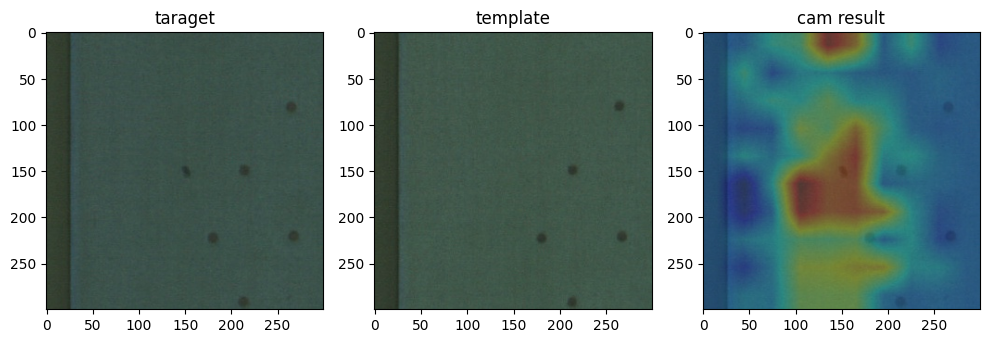

In [48]:
%matplotlib inline
fig, axes = plt.subplots(1,3, figsize=(10,30))

axes[0].imshow(cv2.cvtColor(np.uint8(255 * inv_tensor).transpose(1,2,0), cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(np.uint8(255 * x_master_inv_tensor).transpose(1,2,0), cv2.COLOR_BGR2RGB))
axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[0].set_title('taraget')
axes[1].set_title('template')
axes[2].set_title('cam result')
fig.tight_layout()
plt.show()